# Setup

**[TRICK](https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting) TO PREVENT COLAB FROM DISCONNECTING ALL THE TIME**

Set a javascript interval to click on the connect button every 60 seconds. Open developer-settings (in your web-browser) with `Ctrl+Shift+I`, then click on console tab and type this on the console prompt:
```
function ClickConnect(){
    console.log("Clicked on toolbar button after 10 minutes"); 
    document.querySelector("colab-toolbar-button").click();
}
clickConnectInterval = setInterval(ClickConnect, 10*60*1000);
```

## Check GPU

P100....❤️

T4.........👍

K80.......👎

In [83]:
# GPU count and name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-d5290cc7-e7da-d956-2618-52c80d77fa1c)


In [84]:
!nvidia-smi

Mon Sep 21 16:03:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    44W / 250W |   8363MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Google Drive

In [85]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Packages

In [86]:
!pip install tensorflow==2.3.0

## Import

In [87]:
## deep learning
import math
import scipy.linalg 
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder 

# FID
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

## image preprocess
import imageio
import cv2
from PIL import Image
import albumentations as A
from skimage.transform import rescale, resize, downscale_local_mean

## misc
import os
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython import display
import xml.etree.ElementTree as ET
from typeguard import typechecked
import time
from datetime import datetime


import warnings
warnings.filterwarnings('ignore')

## Configuration

#### Run settings

In [88]:
img_height = 64
img_width = img_height
num_classes = 120

In [89]:
# Choose if you are training or not
training = True

epochs_so_far = 1200
n_epochs = 1500

# Choose if load a previously saved model or not
load_model = True

print(f"Trained for {epochs_so_far} epochs. " \
f"Training further to reach {n_epochs} epochs. " \
f"Loading model: {load_model}."
)

Trained for 1200 epochs. Training further to reach 1500 epochs. Loading model: True.


In [90]:
# Different paths
project_path = "/content/drive/My Drive/VisionPerception"
# use_model = "BigGAN" 
use_model = "DCGAN"

dataset_folder_path = os.path.join(
    project_path, 
    "Dataset/StanfordDogs"
)

dataset_path = os.path.join(
    dataset_folder_path, 
    f"StanfordDogs_{img_height}.npy"
)
dataset_labels_path = os.path.join(
    dataset_folder_path, 
    f"StanfordDogs_{img_height}_labels.npy"
)

# To restore training in different sessions
saved_models_folder = os.path.join(
    project_path,
    "SavedModel"
)

checkpoint_folder = os.path.join(
    saved_models_folder,
    f"{use_model}_dogs_{img_height}"
)

save_folder = os.path.join(
    saved_models_folder,
    f"{use_model}_dogs_{img_height}_{n_epochs}_epochs"
)


checkpoint_path = os.path.join(
    checkpoint_folder,
    "checkpoint.ckpt"
)

save_path = os.path.join(
    save_folder,
    "checkpoint.ckpt"
)

print(f"Saving checkpoints to {checkpoint_path}.")
print(f"Saving model to {save_path}.")

Saving checkpoints to /content/drive/My Drive/VisionPerception/SavedModel/DCGAN_dogs_64/checkpoint.ckpt.
Saving model to /content/drive/My Drive/VisionPerception/SavedModel/DCGAN_dogs_64_1500_epochs/checkpoint.ckpt.


#### Hyperparameters

In [91]:
CONFIG = {
    "batch_size": 128, 
    "latent_dim": 128,
    "channels": 64,
    "use_spec_norm": True,
    "use_attention": True,
    "use_orth_init": True,
    "use_orth_reg": True,
    "d_steps": 2, # 1,
    "gp_lambda": 10.0,
    "loss": "sgan",
    "smooth_labels": True,
    "label_smoothness": 0.3,
    "label_noise": 0.05,
    "lr_d": 2e-4, # 2e-4, 
    "lr_g": 5e-5, #2e-4,
    "exp_decay": False,
    "decay_rate": 0.95,
    "decay_steps": 1000,
    "beta1": 0.0, # 0.5
    "beta2": 0.999,
    "seed": 2020
}

In [92]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [93]:
set_seed(CONFIG["seed"])

# Data

## StanfordDogs

### Dowloading the dataset

In [94]:
# !mkdir ./Dataset

In [95]:
# !wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -P ./Dataset

In [96]:
# !wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar -P ./Dataset

In [97]:
# !tar xf ./Dataset/images.tar -C ./Dataset

In [98]:
# !tar xf ./Dataset/annotation.tar -C ./Dataset

### Preparing the dataset

If we look at the dataset, we can see that each annotation folder contains a list of <b>xml</b> files. These files are associated with a specific image and contain very useful information, mainly the bounding boxes around each dog in the image. There are also images with more than one dog in them and this allows us to accurately crop them and make a dataset that contains <b>single dogs only</b> images.

Here we can utilize the <b>xml</b> library to create a tree and find the relevant elements for that annotation. For each object we can extract the bounding box coordinates, crop the images and normalize the crop by <b>shrinking</b> or <b>expanding</b> it depending on the result <b>image width</b>. Finally, we'll save the images in a numpy array.

In [99]:
# images_dir = "./Dataset/Images/"
# ann_dir = "./Dataset/Annotation/"

In [100]:
# all_breeds = os.listdir(images_dir)
# all_files = [file for breed in all_breeds for file in os.listdir(os.path.join(images_dir, breed))]

In [101]:
# breeds = glob.glob(ann_dir+'*')
# annotations = []
# for breed in breeds:
#     annotations += glob.glob(breed+'/*')

In [102]:
# breed_map = {}
# for annotation in annotations:
#     breed = annotation.split('/')[-2]
#     index = breed.split('-')[0]
#     breed_map.setdefault(index, breed)

In [103]:
# all_labels = [breed_map[file.split('_')[0]] for file in all_files]

In [104]:
# le = LabelEncoder()
# all_labels = le.fit_transform(all_labels)
# all_labels = all_labels.astype(np.int32)

In [105]:
# def load_bbox(file):
#     file = os.path.join(breed_map[file.split('_')[0]], file.split('.')[0])
#     path = os.path.join(ann_dir, file)
#     tree = ET.parse(path)
#     root = tree.getroot()
#     objects = root.findall('object')
#     for o in objects:
#         bndbox = o.find('bndbox')
#         xmin = int(bndbox.find('xmin').text)
#         ymin = int(bndbox.find('ymin').text)
#         xmax = int(bndbox.find('xmax').text)
#         ymax = int(bndbox.find('ymax').text)
    
#     return (xmin, ymin, xmax, ymax)

In [106]:
# all_bboxes = [load_bbox(file) for file in all_files]

In [107]:
# print('Total files       : {}'.format(len(all_files)))
# print('Total labels      : {}'.format(len(all_labels)))
# print('Total bboxes      : {}'.format(len(all_bboxes)))
# print('Total annotations : {}'.format(len(annotations)))
# print('Total classes     : {}'.format(len(le.classes_)))

In [108]:
# def get_resized_bbox(height, width, bbox):
#     """
#     Make square bounding boxes of original ones,
#     to keep a dog's aspect ratio.
#     """
#     xmin, ymin, xmax, ymax = bbox
#     xlen = xmax - xmin
#     ylen = ymax - ymin
    
#     if xlen > ylen:
#         diff = xlen - ylen
#         min_pad = min(ymin, diff//2)
#         max_pad = min(height-ymax, diff-min_pad)
#         ymin = ymin - min_pad
#         ymax = ymax + max_pad

#     elif ylen > xlen:
#         diff = ylen - xlen
#         min_pad = min(xmin, diff//2)
#         max_pad = min(width-xmax, diff-min_pad)
#         xmin = xmin - min_pad
#         xmax = xmax + max_pad
    
#     return xmin, ymin, xmax, ymax

In [109]:
# resized_bboxes = []
# for file, bbox in zip(all_files, all_bboxes):
#     file = os.path.join(breed_map[file.split('_')[0]], str(file))
#     path = os.path.join(images_dir, file)
#     img = Image.open(path)
#     width, height = img.size
#     xmin, ymin, xmax, ymax = get_resized_bbox(height, width, bbox)
#     resized_bboxes.append((xmin, ymin, xmax, ymax))

In [110]:
# all_images = []
# dim = 64
# for file, bbox in tqdm(zip(all_files, resized_bboxes), total=len(all_files)):
#     file = os.path.join(breed_map[file.split('_')[0]], str(file))
#     path = os.path.join(images_dir, file)

#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     xmin, ymin, xmax, ymax = bbox
#     img = img[ymin:ymax,xmin:xmax]

#     transform = A.Compose([A.Resize(dim, dim, interpolation=cv2.INTER_AREA),
#                            A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#     img = transform(image=img)['image']
#     all_images.append(img)

In [111]:
# all_images = np.array(all_images)

### Saving the dataset

In [112]:
# print(all_images.shape, all_labels.shape)
# print(all_images.dtype, all_labels.dtype)

In [113]:
# print("Saving on Google Drive...")
# np.save("/content/drive/My Drive/VisionPerception/Dataset/StanfordDogs/StanfordDogs_64.npy", all_images)
# np.save("/content/drive/My Drive/VisionPerception/Dataset/StanfordDogs/StanfordDogs_64_labels.npy", all_labels)
# print("Done.")

## Preprocessing

### Normalization

Not necessary since data already preprocessed in $[-1, 1]$.

### Data augmentation

Just random horizontal flip.

In [114]:
@tf.function
def augment(img):
    # random mirroring
    img = tf.image.random_flip_left_right(img)

    # # randomly adjust saturation and brightness
    # img = tf.image.random_saturation(img, 0, 1)
    # img = tf.image.random_brightness(img, 0.1)
    # img = tf.clip_by_value(img, -1., 1.)

    return img

DCGAN will ignore the label.

In [115]:
@tf.function
def preprocess(img, y):
    # normalization in [-1, 1]
    # img = normalize(img)

    # data augmentation
    img = augment(img)
    
    return img, y

## TensorFlow Dataset

In [116]:
# Load data
train_data = np.load(dataset_path)
train_labels = np.load(dataset_labels_path)

# Build Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))

In [117]:
# Apply preprocessing   
train_dataset = train_dataset.map(preprocess)

# Shuffle and batch
train_dataset = train_dataset.shuffle(buffer_size=train_data.shape[0]).batch(CONFIG["batch_size"])

# For performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Model definition

## DCGAN

### Generator

In [118]:
class DCGANGenerator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.z_dim = CONFIG["latent_dim"]
    
        self.dense = layers.Dense(8*8*512, use_bias=False)
        self.bn = layers.BatchNormalization(axis=-1)
        self.reshape = layers.Reshape([8, 8, 512])
        
        # 8 -> 16
        self.deconv1 = layers.Conv2DTranspose(256, 5, 1, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization(axis=-1)

        # 16 -> 32
        self.deconv2 = layers.Conv2DTranspose(128, 5, 2, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization(axis=-1)

        # 32 -> 64
        self.deconv3 = layers.Conv2DTranspose(64, 5, 2, padding='same', use_bias=False)
        self.bn3 = layers.BatchNormalization(axis=-1)

        self.final_deconv = layers.Conv2DTranspose(3, 5, 2, padding='same', use_bias=False, activation='tanh')
    
    def call(self, x, y, training=True): 
        # 128 -> 8*8*512 -> 8, 8, 512    
        h = self.dense(x)
        h = self.bn(h)
        h = tf.nn.relu(h)
        h = self.reshape(h)

        # 8 -> 16
        h = self.deconv1(h)
        h = self.bn1(h)
        h = tf.nn.relu(h)

        # 16 -> 32
        h = self.deconv2(h)
        h = self.bn2(h)
        h = tf.nn.relu(h)

        # 32 -> 64
        h = self.deconv3(h)
        h = self.bn3(h)
        h = tf.nn.relu(h)

        o = self.final_deconv(h)
        return o
    
    def model(self):
        x = layers.Input(shape=(self.z_dim))
        y = layers.Input(shape=(1), dtype=tf.int32)
        return tf.keras.Model(inputs=[x, y], outputs=self.call(x, y))
    
    def summary(self):
        return self.model().summary()

### Discriminator

In [119]:
class DCGANDiscriminator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.w, self.h = img_width, img_height
        
        self.conv1 = layers.Conv2D(64, 5, 2, padding='same', input_shape=[self.w, self.h, 3])
        self.dp1 = layers.Dropout(0.3)

        # 32 -> 16
        self.conv2 = layers.Conv2D(128, 5, 2, padding='same')
        self.dp2 = layers.Dropout(0.3)

        
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)

    def call(self, x, y, training=True):
        
        # 64 -> 32
        h = self.conv1(x)
        h = tf.nn.leaky_relu(h)
        h = self.dp1(h)

        # 32 -> 16
        h = self.conv2(h)
        h = tf.nn.leaky_relu(h)
        h = self.dp2(h)

        h = self.flatten(h)
        o = self.dense(h)

        return o

    def model(self):
        x = layers.Input(shape=[self.h, self.w, 3])
        y = layers.Input(shape=(1), dtype=tf.int32)
        return tf.keras.Model(inputs=[x, y], outputs=self.call(x, y))
    
    def summary(self):
        return self.model().summary()

## BigGAN

### Layers

Defining the various layers needed to implement BigGAN.

#### Regularization

Layers for regularization.

##### Orthogonal Regularizer

In [120]:
class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, beta=1e-04):
        self.beta = beta

    def __call__(self, w):
        """
        Orthogonal regularization modified to relax the constraint while
        still imparting the desired smoothness to our models. 
        This modified version removes the diagonal terms from the regularization, 
        and aims to minimize the pairwise cosine similarity between filters 
        without constraining their norm.

            beta * (||W^T W * (1 - I)||_F)^2

        where 
            || M ||_F = sqrt( sum_ij {| M_ij |} ) 
        
        is the Frobenius norm.
        """
        w_shape = tf.shape(w)
        bs, h, w, ch = w_shape[0], w_shape[1], w_shape[2], w_shape[-1]

        w = tf.reshape(w, [bs, h*w, ch])
        wtw = tf.matmul(w, w, transpose_a=True)
        ones = tf.ones_like(wtw)

        res = wtw * ones - wtw
        norm_squared = tf.reduce_sum(tf.abs(res))
        return self.beta * norm_squared

    def get_config(self):
        return {'beta': self.beta}


##### Spectral Normalization

Taken from a pull request to TFAddons.

In [121]:
# Copyright 2020 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# =============================================================================

class SpectralNormalization(tf.keras.layers.Wrapper):
    """Performs spectral normalization on weights.
    This wrapper controls the Lipschitz constant of the layer by
    constraining its spectral norm, which can stabilize the training of GANs.
    See [Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957).
    ```python
    net = SpectralNormalization(
        tf.keras.layers.Conv2D(2, 2, activation="relu"),
        input_shape=(32, 32, 3))(x)
    net = SpectralNormalization(
        tf.keras.layers.Conv2D(16, 5, activation="relu"))(net)
    net = SpectralNormalization(
        tf.keras.layers.Dense(120, activation="relu"))(net)
    net = SpectralNormalization(
        tf.keras.layers.Dense(n_classes))(net)
    ```
    Arguments:
      layer: A `tf.keras.layers.Layer` instance that
        has either `kernel` or `embeddings` attribute.
      power_iterations: `int`, the number of iterations during normalization.
    Raises:
      AssertionError: If not initialized with a `Layer` instance.
      ValueError: If initialized with negative `power_iterations`.
      AttributeError: If `layer` does not has `kernel` or `embeddings` attribute.
    """

    def __init__(self, layer: tf.keras.layers, power_iterations: int = 1, **kwargs):
        super().__init__(layer, **kwargs)
        if power_iterations <= 0:
            raise ValueError(
                "`power_iterations` should be greater than zero, got "
                "`power_iterations={}`".format(power_iterations)
            )
        self.power_iterations = power_iterations
        self._initialized = False

    def build(self, input_shape):
        """Build `Layer`"""
        super().build(input_shape)
        input_shape = tf.TensorShape(input_shape)
        self.input_spec = tf.keras.layers.InputSpec(shape=[None] + input_shape[1:])

        if hasattr(self.layer, "kernel"):
            self.w = self.layer.kernel
        elif hasattr(self.layer, "embeddings"):
            self.w = self.layer.embeddings
        else:
            raise AttributeError(
                "{} object has no attribute 'kernel' nor "
                "'embeddings'".format(type(self.layer).__name__)
            )

        self.w_shape = self.w.shape.as_list()

        self.u = self.add_weight(
            shape=(1, self.w_shape[-1]),
            initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            trainable=False,
            name="sn_u",
            dtype=self.w.dtype,
        )

    def call(self, inputs, training=None):
        """Call `Layer`"""
        if training is None:
            training = tf.keras.backend.learning_phase()

        if training:
            self.normalize_weights()

        output = self.layer(inputs)
        return output

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(self.layer.compute_output_shape(input_shape).as_list())

    @tf.function
    def normalize_weights(self):
        """Generate spectral normalized weights.
        This method will update the value of `self.w` with the
        spectral normalized value, so that the layer is ready for `call()`.
        """

        w = tf.reshape(self.w, [-1, self.w_shape[-1]])
        u = self.u

        with tf.name_scope("spectral_normalize"):
            for _ in range(self.power_iterations):
                v = tf.math.l2_normalize(tf.matmul(u, w, transpose_b=True))
                u = tf.math.l2_normalize(tf.matmul(v, w))

            sigma = tf.matmul(tf.matmul(v, w), u, transpose_b=True)

            self.w.assign(self.w / sigma)
            self.u.assign(u)

    def get_config(self):
        config = {"power_iterations": self.power_iterations}
        base_config = super().get_config()
        return {**base_config, **config}

##### Conditional Batch Normalization

In [122]:
class ConditionalBatchNormalization(layers.Layer):
    def __init__(self, num_channels):
        super().__init__()
    
        self.bn = layers.BatchNormalization(axis=-1, center=False, epsilon=1e-4)
        self.dense = layers.Dense(num_channels * 2)

    def call(self, x, y, training=True):
        x_shape = tf.shape(x)
        bs = x_shape[0]
        ch = x_shape[-1]

        emb = self.dense(y, training=training)
        bn = self.bn(x, training=training)
        gamma, beta = tf.split(emb, 2, axis=-1)

        gamma = tf.reshape(gamma, [bs, 1, 1, ch])
        beta = tf.reshape(beta, [bs, 1, 1, ch])

        bn = gamma * bn + beta
        
        return bn

#### FullyConnected, Convolutional and Deconvolotional layers with Spectral Normalization

In [123]:
class FullyConnected(layers.Layer):
    def __init__(self, units, sn=True):
        super().__init__()
        self.units = units
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

        if sn:
            self.fc = SpectralNormalization(layers.Dense(
                self.units,
                kernel_initializer=initializer,
            ))
        else:
            self.fc = layers.Dense(
                self.units,
                kernel_initializer=initializer,
            )

    def call(self, x, training=True):
        o = self.fc(x, training=training)
        return o

In [124]:
class Conv(layers.Layer):
    def __init__(self, filters, kernel=3, stride=1,
                 use_bias=True, sn=True,
                 regularizer=None):
        
        super().__init__()

        if CONFIG["use_orth_init"]:
            initializer = tf.keras.initializers.Orthogonal()
        else:
            initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)
        
        if sn:
            self.conv = SpectralNormalization(layers.Conv2D(
                filters, kernel, stride,
                padding='same',
                kernel_initializer=initializer,
                kernel_regularizer=regularizer,
                use_bias=use_bias,
                data_format='channels_last'
            ))
        else:
            self.conv = layers.Conv2D(
                filters, kernel, stride,
                padding='same',
                kernel_initializer=initializer,
                kernel_regularizer=regularizer,
                use_bias=use_bias,
                data_format='channels_last'
            )
        
    def call(self, x, training=True):
        o = self.conv(x, training=training)
        return o

In [125]:
class Deconv(layers.Layer):
    def __init__(self, filters, kernel=3, stride=1,
                 use_bias=True, sn=True,
                 regularizer=None):
        
        super().__init__()

        if CONFIG["use_orth_init"]:
            initializer = tf.keras.initializers.Orthogonal()
        else:
            initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)
            
        if sn:
            self.deconv = SpectralNormalization(layers.Conv2DTranspose(
                filters, kernel, stride,
                padding='same',
                kernel_initializer=initializer,
                kernel_regularizer=regularizer,
                use_bias=use_bias,
                data_format='channels_last'
            ))
        else:
            self.deconv = layers.Conv2D(
                filters, kernel, stride,
                padding='same',
                kernel_initializer=initializer,
                kernel_regularizer=regularizer,
                use_bias=use_bias,
                data_format='channels_last'
            )
        
    def call(self, x, training=True):
        o = self.deconv(x, training=training)
        return o

#### Residual blocks

In [126]:
class ResBlock(layers.Layer):
    def __init__(self, in_channels, out_channels, 
                 use_bias=True, sn=True,
                 regularizer=None):
        super().__init__()

        self.conv1 = Conv(in_channels, kernel=3, use_bias=use_bias, sn=sn,
                          regularizer=regularizer)

        self.conv2 = Conv(out_channels, kernel=3, use_bias=use_bias, sn=sn,
                          regularizer=regularizer)

    def residual(self, x, training=True):
        h = tf.nn.leaky_relu(x)
        h = self.conv1(h, training=training)

        h = tf.nn.leaky_relu(h)
        o = self.conv2(h, training=training)

        return o

    def shortcut(self, x, training=training):
        return x

    def call(self, x, training=True):
        residual = self.residual(x)
        shortcut = self.shortcut(x)        

        return residual + shortcut

In [127]:
class ResBlockUp(layers.Layer):
    def __init__(self, in_channels, out_channels, 
                 use_bias=True, sn=True,
                 regularizer=None):
        super().__init__()

        self.cbn1 = ConditionalBatchNormalization(in_channels)
        self.deconv1 = Deconv(in_channels, kernel=3, stride=2,
                          use_bias=use_bias, sn=sn,
                          regularizer=regularizer)        

        self.cbn2 = ConditionalBatchNormalization(in_channels)
        self.deconv2 = Deconv(out_channels, kernel=3, stride=1, 
                            use_bias=use_bias, sn=sn,
                            regularizer=regularizer)

        self.deconv_sc = Deconv(out_channels, kernel=1, stride=2,
                            use_bias=use_bias, sn=sn,
                            regularizer=regularizer)

    def residual(self, x, y, training=True):
        h = self.cbn1(x, y, training=training)
        h = tf.nn.leaky_relu(h)
        h = self.deconv1(h, training=training)

        h = self.cbn2(h, y, training=training)
        h = tf.nn.leaky_relu(h)
        o = self.deconv2(h, training=training)

        return o

    def shortcut(self, x, training=True):
        o = self.deconv_sc(x, training=training)
        return o

    def call(self, x, y, training=training):
        residual = self.residual(x, y)
        shortcut = self.shortcut(x)        

        return residual + shortcut

In [128]:
class ResBlockDown(layers.Layer):
    def __init__(self, in_channels, out_channels, 
                 use_bias=True, sn=True,
                 regularizer=None):
        super().__init__()

        self.conv1 = Conv(out_channels, kernel=3, stride=1, 
                          use_bias=use_bias, sn=sn,
                          regularizer=regularizer)
        
        self.conv2 = Conv(out_channels, kernel=3, stride=2,
                          use_bias=use_bias, sn=sn,
                          regularizer=regularizer)
        
        self.conv_sc = Conv(out_channels, kernel=1, stride=2,
                            use_bias=use_bias, sn=sn,
                            regularizer=regularizer)

    def residual(self, x, training=True):
        h = tf.nn.leaky_relu(x)
        h = self.conv1(h, training=training)

        h = tf.nn.leaky_relu(h)
        o = self.conv2(h, training=training)

        return o

    def shortcut(self, x, training=training):
        o = self.conv_sc(x, training=training)
        return o

    def call(self, x, training=True):
        residual = self.residual(x)
        shortcut = self.shortcut(x)        

        return residual + shortcut

#### Self attention

In [129]:
class SelfAttention(layers.Layer):
    def __init__(
        self, channels, sn=True
    ):
        super().__init__()
        self.channels = channels

        self.gamma = self.add_weight(
            name="gamma",
            shape=(),
            initializer=tf.initializers.constant(0.0),
            trainable=True,
        )

        self.conv_query = Conv(channels, kernel=1, use_bias=False, sn=sn)
        self.conv_key = Conv(channels, kernel=1, use_bias=False, sn=sn)
        self.conv_value = Conv(channels, kernel=1, use_bias=False, sn=sn)
        self.conv_attn = Conv(channels, kernel=1, use_bias=False, sn=sn)

    def call(self, x, training=True):
        input_shape = tf.shape(x)
        
        bs = input_shape[0]
        h = input_shape[1]
        w = input_shape[2]
        ch = self.channels

        # Computing key, query, value
        query = self.conv_query(x, training=training)
        key = self.conv_key(x, training=training)
        value = self.conv_value(x, training=training)
        
        # Flattening the "first" (after batch) dimension
        # (batch_size, N, channels)
        query = tf.reshape(query, [bs, h*w, ch])
        key = tf.reshape(key, [bs, h*w, ch])
        value = tf.reshape(value, [bs, h*w, ch])

        # [bs, ch/8, N]
        query = tf.transpose(query, [0, 2, 1])

        # Computing attention map
        attn = tf.matmul(key, query) # [bs, N, ch] * [bs, ch, N] = [bs, N, N]
        attn = tf.nn.softmax(attn)   # [bs, N, N]

        # Computing self-attention feature maps
        attn = tf.matmul(attn, value) # [bs, N, N] * [bs, N, ch] = [bs, N, ch]
        attn = tf.reshape(attn, [bs, h, w, ch])
        attn = self.conv_attn(attn, training=training)
        
        # Final residual (learnable) connection
        o = self.gamma * attn + x
        return o

### Generator

In [130]:
class BigGANGenerator(tf.keras.Model):
    def __init__(self, channels, latent_dim, num_classes, sn=True, attn=True, orth=True):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_upsamples = 4
        self.channels = channels
        self.num_classes = num_classes
        self.attn = attn

        regularizer = OrthogonalRegularizer() if orth else None
        
        # Sequential structure
        ch = self.channels
        
        # (128,) -> (4*4*8ch,)
        self.fc = FullyConnected(units=4 * 4 * 8*ch, sn=sn)
        self.embed_reshape = layers.Reshape([ch])
        self.embed = layers.Embedding(num_classes, ch)
        # -> (4, 4, 8ch)
        self.reshape = layers.Reshape((4, 4, 8*ch))

        # -> (8, 8, 8ch)
        self.res1 = ResBlockUp(8*ch, 8*ch, use_bias=False, sn=sn, regularizer=regularizer)

        # -> (16, 16, 4ch)
        self.res2 = ResBlockUp(8*ch, 4*ch, use_bias=False, sn=sn, regularizer=regularizer)

        # -> (32, 32, 2ch)
        self.res3 = ResBlockUp(4*ch, 2*ch, use_bias=False, sn=sn, regularizer=regularizer)
        if attn:
            self.self_attention = SelfAttention(2*ch, sn=sn)

        # -> (64, 64, ch)
        self.res4 = ResBlockUp(2*ch, ch, use_bias=False, sn=sn, regularizer=regularizer)
        self.bn = layers.BatchNormalization(axis=-1)

        # -> (64, 64, 3)
        self.conv = Conv(3, kernel=3, use_bias=False, sn=sn, regularizer=regularizer)

        
    def call(self, z, y, training=True):
        y = self.embed_reshape(self.embed(y))
        
        h = self.fc(z, training=training)
        h = self.reshape(h)

        h = self.res1(h, y, training=training)
        h = self.res2(h, y, training=training)
        h = self.res3(h, y, training=training)
        if self.attn:
            h = self.self_attention(h, training=training)
        
        h = self.res4(h, y, training=training)

        h = self.bn(h, training=training)
        h = tf.nn.leaky_relu(h)
        o = self.conv(h, training=training)
        o = tf.keras.activations.tanh(o)

        return o

    def model(self):
        x = layers.Input(shape=(self.latent_dim))
        y = layers.Input(shape=(1), dtype=tf.int32)
        return tf.keras.Model(inputs=[x, y], outputs=self.call(x, y))
    
    def summary(self):
        return self.model().summary()


### Discriminator

In [131]:
class BigGANDiscriminator(tf.keras.Model):
    def __init__(self, channels, w, h, num_classes, sn=True, attn=True):
        super().__init__()
        self.w = w
        self.h = h
        self.num_classes = num_classes

        self.channels = channels
        ch = self.channels

        # Sequential structure
        # (64, 64, 3) -> (32, 32, ch)
        self.res1 = ResBlockDown(3, ch, use_bias=False, sn=sn)
        if attn:
            self.self_attention = SelfAttention(ch, sn=sn)
        
        # -> (16, 16, 4ch)
        self.res2 = ResBlockDown(ch, 2*ch, use_bias=False, sn=sn)
        
        # -> (8, 8, 8ch)
        self.res3 = ResBlockDown(2*ch, 4*ch, use_bias=False, sn=sn)
        
        # -> (4, 4, 8ch)
        self.res4 = ResBlockDown(4*ch, 8*ch, use_bias=False, sn=sn)
        
        self.linear = FullyConnected(units=1, sn=sn)
        self.embed = layers.Embedding(
            num_classes, ch*8, 
        )

        self.attn = attn

    def call(self, x, y, training=True):
        """
        Implementation of BigGAN discriminator.
        Taken from arXiv:1809.11096v2.
        """
        # squeezing if necessary
        y_shape = tf.shape(y)
        y = tf.reshape(y, shape=[-1])
        emb = self.embed(y)
        
        h = self.res1(x, training=training)    
        if self.attn:    
            h = self.self_attention(h, training=training)
        h = self.res2(h, training=training)
        h = self.res3(h, training=training)
        h = self.res4(h, training=training)

        # global sum pooling
        h = tf.nn.leaky_relu(h)
        h = tf.reduce_sum(h, axis=[1, 2])
        
        linear = self.linear(h, training=training)
        inner = tf.reduce_sum(h*emb, axis=-1, keepdims=True)
        
        o = linear + inner
        return o
    
    def model(self):
        x = layers.Input(shape=(self.h, self.w, 3))
        y = layers.Input(shape=(), dtype=tf.int32)
        return tf.keras.Model(inputs=[x, y], outputs=self.call(x, y))
    
    def summary(self):
        return self.model().summary()

## GAN

### Losses

Functions to perform label smooothing.

In [132]:
@tf.function
def smooth_real_labels(y):
    """
    Label smoothing -- technique from GAN hacks, instead of assigning 1/0 as class labels, 
    we assign a random number in range [0.7, 1.0] as label for real images
    """
    return y - tf.random.uniform(tf.shape(y), minval=0, maxval=CONFIG["label_smoothness"])

@tf.function
def smooth_fake_labels(y):
    """
    Label smoothing -- technique from GAN hacks, instead of assigning 1/0 as class labels, 
    we assign a random number in range [0.0, 0.3] as label for fake images
    """
    return y + tf.random.uniform(tf.shape(y), minval=0, maxval=CONFIG["label_smoothness"])

@tf.function
def noisy_labels(labels, p_flip):
    """
    Randomly flip some labels.

    Args:
        labels: labels to be flipped.
        p_flip: probability of flipping a label.

    Returns:
        Noisy labels.
    """

    # mask to select the labels to be flipped
    mask = tf.cast(
        (tf.random.uniform(tf.shape(labels), minval=0, maxval=1) < p_flip), 
        dtype=tf.float32
    )
    flipped_labels = tf.subtract(1., labels)

    return mask * flipped_labels + (1. - mask) * labels

In [133]:
class SGANDiscriminatorLoss(tf.keras.losses.Loss):
    """
    Standard GAN loss for discriminator.
    """
    def __init__(self):
        super().__init__()
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    def call(self, real_output, fake_output):
        """
        Loss for the discriminator. 
        Applies technique from GAN hacks to stabilize training:
            - Label smoothing
            - Label noise

        Args:
            real_output: output of the discriminator on real images
            fake_output: output of the discriminator on fake (generated) images
        """
        
        # Real images must be predicted 1 (noised and smoothed)
        real_labels = tf.ones_like(real_output)
        if CONFIG["smooth_labels"]:
            real_labels = noisy_labels(real_labels, CONFIG["label_noise"])
            real_labels = smooth_real_labels(real_labels)
        
        # Fake images must be predicted 0 (noised and smoothed)
        fake_labels = tf.zeros_like(fake_output)
        if CONFIG["smooth_labels"]:
            fake_labels = noisy_labels(fake_labels, CONFIG["label_noise"])
            fake_labels = smooth_fake_labels(fake_labels)

        real_loss = self.bce(real_labels, real_output)
        fake_loss = self.bce(fake_labels, fake_output)
        
        total_loss = real_loss + fake_loss
        return total_loss

In [134]:
class SGANGeneratorLoss(tf.keras.losses.Loss):
    """
    Standard GAN loss for generator.
    """
    def __init__(self):
        super().__init__()
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def call(self, real_output, fake_output):
        """
        Loss for the generator. The generator must fool the discriminator,
        making it predict fake images as real.

        Args:
            real_output: output of the discriminator on real images 
                        (actually not used, just to comply with interface function signature)
            fake_output: output of the discriminator on fake (generated) images
        """
        # Generator must fool the discriminator, making it predict fake images as real
        loss = self.bce(tf.ones_like(fake_output), fake_output)
        return loss

In [135]:
class WGANDiscriminatorLoss(tf.keras.losses.Loss):
    """
    Wasserstein loss for the 'critic' from `Wasserstein GAN` (https://arxiv.org/abs/1701.07875).
    """
    def call(self, real_output, gen_output):
        # loss for the output of the discriminator on real images
        real_loss = tf.reduce_mean(real_output)
        # loss for the output of the discriminator on generated images
        gen_loss = tf.reduce_mean(gen_output)
        loss = gen_loss - real_loss
        return loss
    


In [136]:
class WGANGeneratorLoss(tf.keras.losses.Loss):
    """
    Wasserstein loss for the generator from `Wasserstein GAN` (https://arxiv.org/abs/1701.07875).
    """
    def call(self, real_output, gen_output):

        loss = -tf.reduce_mean(gen_output)
        return loss

In [137]:
class RaLSGANGeneratorLoss(tf.keras.losses.Loss):
    def call(self, real_output, fake_output):
        """
        Loss for Relativistic average Least Square GAN (arXiv:1901.02474).
        """
        real_loss = tf.reduce_mean(real_output - tf.reduce_mean(fake_output) + 1)**2
        fake_loss = tf.reduce_mean(fake_output - tf.reduce_mean(real_output) - 1)**2

        loss = (real_loss + fake_loss) / 2

        return loss

In [138]:
class RaLSGANDiscriminatorLoss(tf.keras.losses.Loss):
    def call(self, real_output, fake_output):
        """
        Loss for Relativistic average Least Square GAN (arXiv:1901.02474).
        """
        real_loss = tf.reduce_mean(real_output - tf.reduce_mean(fake_output) - 1)**2
        fake_loss = tf.reduce_mean(fake_output - tf.reduce_mean(real_output) + 1)**2

        loss = (real_loss + fake_loss) / 2

        return loss

### Class definition

In [139]:
class GAN(tf.keras.Model):
    def __init__(
        self, 
        discriminator, 
        generator, 
        latent_dim,
        num_classes,
        d_steps,
        gp_lambda
        ):
        """
        Generative Adversarial Network.

        Args:
            discriminator: discriminator model
            generator:      generator model
            latent_dim:     dimension of the latent space
            d_steps:   number of steps for optimizing the discriminator
        """
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.d_steps = d_steps
        self.gp_lambda = gp_lambda

    def compile(self, d_optim, g_optim, 
                d_loss_fn, g_loss_fn):
        """
        Compiles the GAN, using the standard GAN loss implemented as a 
        BinaryCrossentropy from logits (non-sigmoid discriminator output).

        Args:
            d_optim: Optimizer for the discriminator
            g_optim: Optimizer for the generator
            d_loss_fn: Loss function for the discriminator
            g_loss_fn: Loss function for the generator
        """
        super().compile()
        self.d_optim = d_optim
        self.g_optim = g_optim
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def call(self, batch, training=True):
        """
        Calling just the generator.

        Args:
            inputs: latent vector for the generator

        Returns:
            The generated image from the generator.
        """
        x, y = batch
        return self.generator(x, y, training=training)
    
    def gradient_penalty(self, real_images, fake_images, lam=10):
        """ 
        Calculates the gradient penalty.
        This loss is calculated on an interpolated image and added to the discriminator loss.
        """
        
        bs = tf.shape(real_images)[0]
        epsilon = tf.random.uniform(shape=[bs, 1, 1, 1], minval=0.0, maxval=1.0)
        interpolated = epsilon * real_images + (1 - epsilon) * fake_images

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        
        return gp

    def compute_d_loss(self, real_output, fake_output):
        d_loss = self.d_loss_fn(real_output, fake_output)
        if isinstance(self.d_loss_fn, WGANDiscriminatorLoss):
            gp = self.gradient_penalty(real_images, fake_images)
            d_loss = d_loss + self.gp_lambda * gp
        
        return d_loss
    
    def compute_g_loss(self, real_output, fake_output):
        if isinstance(self.g_loss_fn, RaLSGANGeneratorLoss):
            g_loss = self.g_loss_fn(real_output, fake_output)
        else:
            g_loss = self.g_loss_fn(_, fake_output)
        
        return g_loss

    def train_step(self, batch):
        """
        Performs one step of GAN training:
            1. Sample a batch of real images
            2. Train the discriminator for d_steps steps
                2.1. Sample a batch of priors from latent space
                2.2. Generate a batch of fake images from those priors
                2.3. Obtain the discriminator prediction on both the real and fake images
                2.4. Optimize the discriminator based on its predictions
            3. Train the generator
                3.1. Sample a batch of priors from latent space
                3.2. Generate a batch of fake images from those priors
                3.3. Obtain the discriminator prediction on the fake images
                3.4. Optimize the generator based on the discriminator predictions

        Args:
            batch: contains
                real_images: batch of real images of dimension (batch_size, img_width, img_height, 3)
                real_labels: batch of labels for the real images of dimension (batch_size, 1)
        """
        real_images, real_labels = batch
        bs = tf.shape(real_images)[0]
        
        d_loss_total = 0.0
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(
                shape=(bs, self.latent_dim)
            )
            random_labels = tf.math.floor(self.num_classes * tf.random.uniform(shape=[bs, 1]))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, random_labels, training=True)
                real_output = self.discriminator(real_images, real_labels, training=True)
                fake_output = self.discriminator(fake_images, random_labels, training=True)

                d_loss = self.compute_d_loss(real_output, fake_output)
                d_loss = d_loss / self.d_steps
                d_loss_total += d_loss

            d_grad = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optim.apply_gradients(
                zip(d_grad, self.discriminator.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(bs, self.latent_dim)
        )
        random_labels = tf.math.floor(self.num_classes * tf.random.uniform(shape=[bs,1]))

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, random_labels, training=True)
            fake_output = self.discriminator(fake_images, random_labels, training=True)
            g_loss = self.compute_g_loss(real_output, fake_output)
            
        g_grad = tape.gradient(g_loss, self.generator.trainable_variables)
        
        self.g_optim.apply_gradients(
            zip(g_grad, self.generator.trainable_variables)
        )

        return {"d_loss": d_loss_total, "g_loss": g_loss}

# Model building

### Optimizers

In [140]:
lr_d = CONFIG["lr_d"]
lr_g = CONFIG["lr_g"]
beta_1 = CONFIG["beta1"]
beta_2 = CONFIG["beta2"]

In [141]:
if CONFIG["exp_decay"]:
    decay_rate = CONFIG["decay_rate"]
    decay_steps = CONFIG["decay_steps"]
    
    lr_d = tf.keras.optimizers.schedules.ExponentialDecay(
        lr_d,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )

    lr_g = tf.keras.optimizers.schedules.ExponentialDecay(
        lr_g,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )

In [142]:
d_optim = tf.keras.optimizers.Adam(
    learning_rate=lr_d, beta_1=beta_1, beta_2=beta_2
)

g_optim = tf.keras.optimizers.Adam(
    learning_rate=lr_g, beta_1=beta_1, beta_2=beta_2
)

## Build

In [143]:
if use_model == 'DCGAN':
    print("Building discriminator...")
    discriminator = DCGANDiscriminator()
    print("Done.")
    print("Building generator...")
    generator = DCGANGenerator()
    print("Done.")

    print("Building GAN...")
    gan = GAN(
        discriminator=discriminator, 
        generator=generator, 
        latent_dim=CONFIG["latent_dim"],
        num_classes=num_classes,
        d_steps=CONFIG["d_steps"],
        gp_lambda=CONFIG["gp_lambda"]
    )
    print("Done.")

Building discriminator...
Done.
Building generator...
Done.
Building GAN...
Done.


In [144]:
if use_model == 'BigGAN':
    print("Building discriminator...")
    discriminator = BigGANDiscriminator(
        channels=CONFIG["channels"], w=img_width, h=img_height, num_classes=num_classes,
        sn=CONFIG["use_spec_norm"], attn=CONFIG["use_attention"]
    )
    print("Done.")
    print("Building generator...")
    generator = BigGANGenerator(
        channels=CONFIG["channels"], latent_dim=CONFIG["latent_dim"], num_classes=num_classes,
        sn=CONFIG["use_spec_norm"], attn=CONFIG["use_attention"], orth=CONFIG["use_orth_reg"]
    )
    print("Done.")

    print("Building GAN...")
    gan = GAN(
        discriminator=discriminator, 
        generator=generator, 
        latent_dim=CONFIG["latent_dim"],
        num_classes=num_classes,
        d_steps=CONFIG["d_steps"],
        gp_lambda=CONFIG["gp_lambda"]
    )
    print("Done.")

## Compile

In [145]:
if CONFIG["loss"] == "sgan":
    d_loss_fn = SGANDiscriminatorLoss()
    g_loss_fn = SGANGeneratorLoss()
elif CONFIG["loss"] == "wgan":
    d_loss_fn = WGANDiscriminatorLoss()
    g_loss_fn = WGANGeneratorLoss()
elif CONFIG["loss"] == "ralsgan":
    d_loss_fn = RaLSGANDiscriminatorLoss()
    g_loss_fn = RaLSGANGeneratorLoss()

In [146]:
print("Compiling GAN...")
gan.compile(
    d_optim=d_optim,
    g_optim=g_optim,
    d_loss_fn=d_loss_fn,
    g_loss_fn=g_loss_fn
)
print("Done.")

Compiling GAN...
Done.


## Summary

In [147]:
disc = gan.discriminator
gen = gan.generator

In [148]:
gen.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32768)        4194304     input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 32768)        131072      dense_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Relu (TensorFlowOpL [(None, 32768)]      0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [149]:
disc.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 32, 32, 64)   4864        input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu (TensorFl [(None, 32, 32, 64)] 0           conv2d_94[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 32, 64)   0           tf_op_layer_LeakyRelu[0][0]      
_______________________________________________________________________________________

## Load model

In [150]:
if load_model:
    print("Loading model...")
    random_latent_vectors = tf.random.normal(
        shape=(1, CONFIG["latent_dim"])
    )
    random_labels = tf.math.floor(num_classes * tf.random.uniform((1,1)))

    inputs = (random_latent_vectors, random_labels)
    
    _ = gan(inputs)
    
    path = checkpoint_path
    # path = "/content/drive/My Drive/VisionPerception/SavedModel/BigGAN_dogs_64_450_epochs/checkpoint.ckpt"
    gan.load_weights(path)
    print("Done.")

Loading model...
Done.


## Sample

Probability of real image being real: tf.Tensor([[0.21056148]], shape=(1, 1), dtype=float32)
Probability of generated image being real: tf.Tensor([[0.31000477]], shape=(1, 1), dtype=float32)


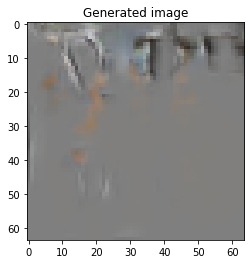

In [151]:
random_latent_vectors = tf.random.truncated_normal(
    shape=(1, CONFIG["latent_dim"])
)
random_labels = tf.math.floor(num_classes * tf.random.uniform((1,1)))

inputs = (random_latent_vectors, random_labels)

gen_imgs = gan(inputs, training=False)

real_imgs, real_labels = next(iter(train_dataset))
real_img = real_imgs[:1, ...]
real_label = real_labels[:1, ...]

pred_real = gan.discriminator(real_img, real_label, training=False)
pred_gen = gan.discriminator(gen_imgs, random_labels, training=False)

print("Probability of real image being real:", tf.nn.sigmoid(pred_real))
print("Probability of generated image being real:", tf.nn.sigmoid(pred_gen))

img = gen_imgs[0]
img = (img + 1.) / 2.
if (img.shape[-1] == 1):
    img = np.squeeze(img, axis=-1)
    plt.title("Generated image")
    plt.imshow(img, cmap='gray')
else:
    plt.title("Generated image")
    plt.imshow(img)
plt.show()

# Training

In [152]:
tf.keras.backend.clear_session()

## Callbacks

Callbacks to calculate FID score during training, and also generate a batch of images, to show progress.

In [153]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [154]:
class FIDCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, period=5):
        super().__init__()
        
        self.period = period
        self.dataset = iter(dataset)
        self.inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

    def compute_fid(self): 
        # real images
        real_images, real_labels = next(self.dataset)
        num_images = real_images.shape[0]
        latent_dim = self.model.latent_dim
        
        # generated images
        latent_samples = tf.random.truncated_normal(shape=(num_images, latent_dim))
        random_labels = tf.math.floor(num_classes * tf.random.uniform((num_images,1)))
        
        inputs = (latent_samples, random_labels)
        
        generated_images = self.model(inputs, training=False)
        
        # resize images
        real_images = scale_images(real_images, (299,299,3))
        generated_images = scale_images(generated_images, (299,299,3))

        # calculate fid
        fid = calculate_fid(self.inception_model, real_images, generated_images)
        return fid

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.period != 0:
            return

        fid = self.compute_fid()
        print(f"\n\n === FID: {fid} ===\n")

In [155]:
def plot_imgs_grid(imgs, save_images=False, 
                   path="/content/drive/My Drive/VisionPerception/GeneratedImages/"):
    n_imgs = imgs.shape[0]
    grid_side = math.sqrt(n_imgs)
    
    fig, axes = plt.subplots(
        int(round(grid_side)), 
        int(round(grid_side)),
        figsize=(n_imgs, n_imgs)
    )
    
    if save_images:
        file_counter = sum([len(files) for r, d, files in os.walk(path)])
    
    axes = np.reshape(axes, (-1,))
    for i, ax in enumerate(axes):
        img = imgs[i, ...]
        img = (img + 1.) / 2.
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)
        if save_images:
            name = 'Dog_'+str(file_counter+i)
            image_path = os.path.join(path,name)
            
            img = 255 * img.numpy()
            img = img.astype('uint8')
            
            cv2.imwrite(image_path+'.jpg', img)
            print("Image saved as: "+name)
    
    plt.show()

In [156]:
class PlotImagesCallback(tf.keras.callbacks.Callback):
    def __init__(self, n_images=16, period=10):
        super().__init__()
        
        self.n_images = n_images
        self.period = period

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.period != 0:
            return

        latent_dim = self.model.latent_dim
        latent_sample = tf.random.truncated_normal(shape=(self.n_images, latent_dim))
        random_labels = tf.math.floor(num_classes * tf.random.uniform((self.n_images,1)))
        
        inputs = (latent_sample, random_labels)
        
        imgs = self.model(inputs, training=False)
        plot_imgs_grid(imgs)

In [157]:
if training:
    mc_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, verbose=0, mode='auto', save_freq='epoch', options=None
    )
    fid_callback = FIDCallback(
        train_dataset, period=10
    )
    plot_callback = PlotImagesCallback(
        n_images=16, period=10
    )
    callbacks = [
        mc_callback,
        fid_callback,
        plot_callback
    ]

## Sanity check

In [158]:
if training:
    batch = next(iter(train_dataset))
    s = time.time()
    gan.train_step(batch)
    e = time.time()
    print(f"Time for step: {e-s} s")

Time for step: 0.4947853088378906 s


## Train

In [159]:
if training:
    try:
        history = gan.fit(
            train_dataset, 
            epochs=n_epochs, 
            initial_epoch=epochs_so_far,
            callbacks=callbacks
        )
    except KeyboardInterrupt:
        print("\n\n")
        print("Training interrupted by user.")

Output hidden; open in https://colab.research.google.com to view.

## Save model

In [160]:
if training: gan.save_weights(save_path)

# Evaluation

## Loss curve

In [161]:
if training:
    plt.plot(history.history['g_loss'], label='generator loss')
    plt.plot(history.history['d_loss'], label = 'discriminator loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.grid(axis='y')
    plt.legend(loc='lower right')
    plt.show()

NameError: ignored

In [ ]:
if training:
    timestamp = datetime.today().strftime('%Y.%m.%d-%H.%M.%S')
    suffix = f"{timestamp}"
    history_filename = f"train_history__{suffix}.npy"
    history_path = os.path.join(save_folder, history_filename)
    np.save(history_path, history.history)

## Visualize results

Image saved as: Dog_16
Image saved as: Dog_17
Image saved as: Dog_18
Image saved as: Dog_19
Image saved as: Dog_20
Image saved as: Dog_21
Image saved as: Dog_22
Image saved as: Dog_23
Image saved as: Dog_24
Image saved as: Dog_25
Image saved as: Dog_26
Image saved as: Dog_27
Image saved as: Dog_28
Image saved as: Dog_29
Image saved as: Dog_30
Image saved as: Dog_31


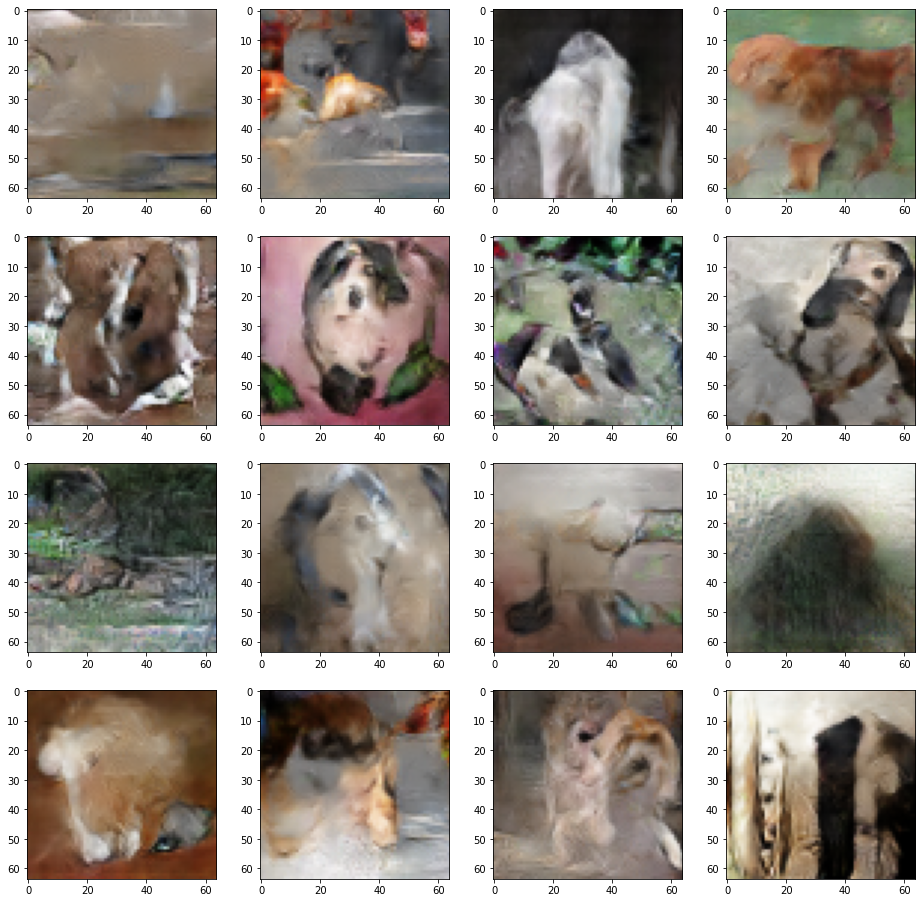

In [162]:
latent_samples = tf.random.truncated_normal(
    shape=(16, CONFIG["latent_dim"])
)
random_labels = tf.math.floor(num_classes * tf.random.uniform(shape=[16, 1]))

inputs = (latent_samples, random_labels)
generated_images = gan(inputs, training=False)

path = "/content/drive/My Drive/VisionPerception/GeneratedImages/"+use_model
plot_imgs_grid(generated_images, save_images=True, path=path)

Create a batch of 16 figures

In [ ]:
num_images = 16
img_size = 64

start_idx = 16

folder = "/content/drive/My Drive/VisionPerception/GeneratedImages/BigGAN"
files = [f for f in os.listdir(folder)]

imgs = np.zeros([64*4, 64*4, 3])

i, j = 0, 0
for f in files:
    if 'Batch' in f:
        continue 
        
    fname = f.split('.')[0]
    idx = int(fname.split('_')[1])
    if idx < start_idx:
        continue
    
    fpath = os.path.join(folder, f)
    img = cv2.imread(fpath)
    img = (1.0 / 255) * img

    imgs[i*64 : (i+1)*64, j*64 : (j+1)*64, :] = img
    j += 1
    if j == 4:
        i += 1
        j = 0

plt.imshow(imgs)
plt.show()

fpath = os.path.join(folder, "Dog_Batch_02.jpg")
imgs = (255 * imgs).astype('uint8')

cv2.imwrite(fpath, imgs)

## FID

In [163]:
def compute_fid(model, real_images): 
	# prepare the inception v3 model
	inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

	# generate images
	num_images = real_images.shape[0]
	latent_samples = tf.random.truncated_normal(shape=(16, CONFIG["latent_dim"]))
	random_labels = tf.math.floor(num_classes * tf.random.uniform(shape=[16, 1]))
	inputs = (latent_samples, random_labels)

	generated_images = gan(inputs, training=False)

	# resize images
	images1 = scale_images(real_images, (299,299,3))
	images2 = scale_images(generated_images, (299,299,3))

	# calculate fid
	fid = calculate_fid(inception_model, images1, images2)
	return fid

In [164]:
num_images = 128

real_imgs, labels = next(iter(train_dataset))
real_imgs = real_imgs[:num_images]

fid = compute_fid(gan, real_imgs)
print('FID: %.3f' % fid)

FID: 345.709
